<a href="https://colab.research.google.com/github/aaperei/data-science/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoder

### Alison Augusto Miranda Pereira - UNIFESP - 2022

## Descrição do problema

O presente trabalho tem o objetivo de explorar o algoritmo `CNN` (*Convolutional Neural Network*) por meio da base de dados `MNIST`.

O artigo ***Variational AutoEncoders (VAE) with PyTorch*** foi utilizado como fonte e referência para os códigos construídos - https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118.

In [91]:
# import libraries
import torch
import torch.nn as nn
from torch import optim
from torchvision import datasets
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
import time

num_epochs = 10
epochs_array = np.array(range(1, num_epochs+1))
stride = 1
padding = 2
kernel_size = 5
learning_rate = 0.01
batch_size = 100
number_of_classes = 10
models = []

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [92]:
# download MNIST dataset in local system
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

print(train_data)
print(test_data)


Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


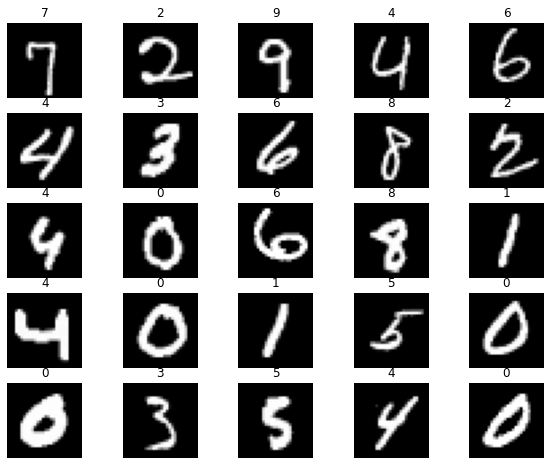

In [93]:
# Visualization of MNIST dataset
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [94]:
# Preparing data for training with DataLoaders
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=batch_size, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=batch_size, 
                                          shuffle=True, 
                                          num_workers=1),
}


# Definição da classe `CNN1`
A classe `CNN1` é subclasse de `nn.Module`, classe padrão do próprio `pytorch` para definição de redes neurais. As seguintes camadas compõem tal modelo:

O modelo `CNN1` é composto por três camadas lineares.
- `conv1`: Canais de entrada 1 / Canais de saída 16 / Maxpolling com kernel de tamanho 2
- `conv2`: Canais de entrada 16 / Canais de saída 32 / Maxpolling com kernel de tamanho 2
- `out`: Entrada (7 * 7 * 32) e saída 10 (representando as 10 classes presentes no `MINIST`.

In [95]:
# Define the Convolutional Neural Network models

# Define CNN1 Class 
class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=kernel_size,              
                stride=stride,                   
                padding=padding,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, kernel_size, stride, padding),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, number_of_classes)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

# Definição da classe `CNN2`
A classe `CNN2` é subclasse de `nn.Module`, classe padrão do próprio `pytorch` para definição de redes neurais. As seguintes camadas compõem tal modelo:

O modelo `CNN2` é composto por três camadas lineares.
- `conv1`: Canais de entrada 1 / Canais de saída 16 / Maxpolling com kernel de tamanho 2
- `conv2`: Canais de entrada 16 / Canais de saída 32 / Maxpolling com kernel de tamanho 2
- `conv3`: Canais de entrada 32 / Canais de saída 64 / Maxpolling com kernel de tamanho 2
- `out` 3: Entrada (3 * 3 * 64) e saída 10 (representando as 10 classes presentes no `MINIST`.

In [96]:
# Define CNN2 Class 
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=stride,                   
                padding=padding,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, kernel_size, stride, padding),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.conv3 = nn.Sequential(         
            nn.Conv2d(32, 64, 5, stride, padding),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(64 * 3 * 3, number_of_classes)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        # flatten the output of conv2 to (batch_size, 64 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

# Definição da classe `CNN3`
A classe `CNN3` é subclasse de `nn.Module`, classe padrão do próprio `pytorch` para definição de redes neurais. As seguintes camadas compõem tal modelo:

O modelo `CNN3` é composto por três camadas lineares.
- `conv1`: Canais de entrada 1 / Canais de saída 16 / Maxpolling com kernel de tamanho 2
- `conv2`: Canais de entrada 16 / Canais de saída 32 / Maxpolling com kernel de tamanho 2
- `conv3`: Canais de entrada 32 / Canais de saída 64 / Maxpolling com kernel de tamanho 2
- `conv4`: Canais de entrada 64 / Canais de saída 128 / Maxpolling com kernel de tamanho 2
- `out` 3: Entrada (1 * 1 * 128) e saída 10 (representando as 10 classes presentes no `MINIST`.

In [97]:
# Define CNN3 Class 
class CNN3(nn.Module):
    def __init__(self):
        super(CNN3, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=kernel_size,              
                stride=stride,                   
                padding=padding,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, kernel_size, stride, padding),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.conv3 = nn.Sequential(         
            nn.Conv2d(32, 64, kernel_size, stride, padding),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.conv4 = nn.Sequential(         
            nn.Conv2d(64, 128, kernel_size, stride, padding),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(128 * 1 * 1, number_of_classes)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # flatten the output of conv2 to (batch_size, 128 * 1 * 1)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

# Definição da classe `CNN4`
A classe `CNN4` é subclasse de `nn.Module`, classe padrão do próprio `pytorch` para definição de redes neurais. As seguintes camadas compõem tal modelo:

O modelo `CNN4` é composto por três camadas lineares.
- `conv1`: Canais de entrada 1 / Canais de saída 16 / Maxpolling com kernel de tamanho 2
- `conv2`: Canais de entrada 16 / Canais de saída 32 / Maxpolling com kernel de tamanho 2
- `conv3`: Canais de entrada 32 / Canais de saída 64 / Maxpolling com kernel de tamanho 2
- `conv4`: Canais de entrada 64 / Canais de saída 128 / Maxpolling com kernel de tamanho 2
- `conv4`: Canais de entrada 64 / Canais de saída 128 / Maxpolling com kernel de tamanho 2
- `conv5`: Canais de entrada 128 / Canais de saída 256 / Sem Maxpolling
- `out` 3: Entrada (1 * 1 * 256) e saída 10 (representando as 10 classes presentes no `MINIST`.

In [98]:
# Define CNN4 Class 
class CNN4(nn.Module):
    def __init__(self):
        super(CNN4, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=kernel_size,              
                stride=stride,                   
                padding=padding,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, kernel_size, stride, padding),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.conv3 = nn.Sequential(         
            nn.Conv2d(32, 64, kernel_size, stride, padding),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.conv4 = nn.Sequential(         
            nn.Conv2d(64, 128, kernel_size, stride, padding),     
            nn.ReLU(),
            nn.MaxPool2d(2),             
        )
        self.conv5 = nn.Sequential(         
            nn.Conv2d(128, 256, kernel_size, stride, padding),     
            nn.ReLU()               
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(256 * 1 * 1, number_of_classes)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        # flatten the output of conv2 to (batch_size, 256 * 1 * 1)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

# Definição da classe `CNN5`
A classe `CNN5` é subclasse de `nn.Module`, classe padrão do próprio `pytorch` para definição de redes neurais. As seguintes camadas compõem tal modelo:

O modelo `CNN5` é composto por três camadas lineares.
- `conv1`: Canais de entrada 1 / Canais de saída 16 / Maxpolling com kernel de tamanho 2
- `conv2`: Canais de entrada 16 / Canais de saída 32 / Maxpolling com kernel de tamanho 2
- `conv3`: Canais de entrada 32 / Canais de saída 64 / Maxpolling com kernel de tamanho 2
- `conv4`: Canais de entrada 64 / Canais de saída 128 / Maxpolling com kernel de tamanho 2
- `conv4`: Canais de entrada 64 / Canais de saída 128 / Maxpolling com kernel de tamanho 2
- `conv5`: Canais de entrada 128 / Canais de saída 256 / Sem Maxpolling
- `conv6`: Canais de entrada 256 / Canais de saída 512 / Sem Maxpolling
- `out` 3: Entrada (1 * 1 * 512) e saída 10 (representando as 10 classes presentes no `MINIST`.

In [99]:
# Define CNN5 Class 
class CNN5(nn.Module):
    def __init__(self):
        super(CNN5, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=kernel_size,              
                stride=stride,                   
                padding=padding,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, kernel_size, stride, padding),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.conv3 = nn.Sequential(         
            nn.Conv2d(32, 64, kernel_size, stride, padding),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.conv4 = nn.Sequential(         
            nn.Conv2d(64, 128, kernel_size, stride, padding),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.conv5 = nn.Sequential(         
            nn.Conv2d(128, 256, kernel_size, stride, padding),     
            nn.ReLU(),              
        )
        self.conv6 = nn.Sequential(         
            nn.Conv2d(256, 512, kernel_size, stride, padding),     
            nn.ReLU(),             
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(512 * 1 * 1, number_of_classes)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

In [100]:
# Define loss function
loss_func = nn.CrossEntropyLoss()   
loss_func

CrossEntropyLoss()

# Treinamento e avaliação dos modelos

In [101]:
# Train the model
def train(num_epochs, cnn_model, loaders):
    average_loss_by_epoch = []
    print("Trainning phase - model ", type(cnn_model), "\n\n")
    print(cnn_model, "\n")
    start_time = time.time()
    # Define a Optimization Function
    optimizer = optim.Adam(cnn_model.parameters(), lr = learning_rate)   
    
    cnn_model.train()
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        loss_sum = 0
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn_model(b_x)[0]               
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()

            loss_sum += loss.item()

            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
                
        average_loss_by_epoch.append(loss_sum/total_step)
    print("\n--- %s seconds spent during trainning ---" % (time.time() - start_time))
    return average_loss_by_epoch

In [102]:
# Evaluate the model on test data
def test(cnn_model):
    print("\n\nEvaluating models on test data - model ", type(cnn_model))
    cnn_model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output, last_layer = cnn_model(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
    
        print('Test Accuracy of the model on the 10000 test images: %.4f' % accuracy)

In [103]:
# Print 10 predictions from test data
def predict_sample_classes(cnn_model):
  sample = next(iter(loaders['test']))
  imgs, lbls = sample

  actual_number = lbls[:10].numpy()

  print("\nPredicting classes - model ", type(cnn_model))
  test_output, last_layer = model(imgs[:10])
  pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
  print(f'Prediction number: {pred_y}')
  print(f'Actual number: {actual_number}')

In [104]:
# Plot line chat - Average loss by epoch
def plot_average_loss_by_epoch(y):
  plt.title("Trainning - Average loss by epoch")
  plt.xlabel("Epoch")
  plt.ylabel("Average loss")
  plt.plot(epochs_array, y, color ="red")
  plt.show()


Trainning phase - model  <class '__main__.CNN1'> 


CNN1(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
) 

Epoch [1/10], Step [100/600], Loss: 0.0789
Epoch [1/10], Step [200/600], Loss: 0.0479
Epoch [1/10], Step [300/600], Loss: 0.0248
Epoch [1/10], Step [400/600], Loss: 0.0899
Epoch [1/10], Step [500/600], Loss: 0.0328
Epoch [1/10], Step [600/600], Loss: 0.1330
Epoch [2/10], Step [100/600], Loss: 0.0133
Epoch [2/10], Step [200/600], Loss: 0.0241
Epoch [2/10], Step [300/600], Loss: 0.0598
Epoch [2/10], Step [400/600], Loss: 0.1025
Epoch [2/10], Step [500/600], Loss: 0.0951


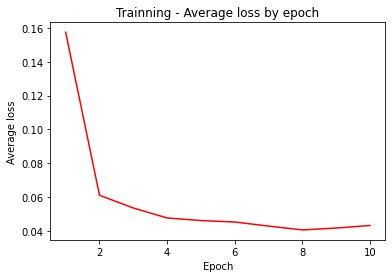



Evaluating models on test data - model  <class '__main__.CNN1'>
Test Accuracy of the model on the 10000 test images: 0.9500

Predicting classes - model  <class '__main__.CNN1'>
Prediction number: [2 6 2 2 4 8 9 9 1 7]
Actual number: [2 6 2 2 4 8 9 9 1 7]
---------------------------------------------------------------------------


Trainning phase - model  <class '__main__.CNN2'> 


CNN2(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  

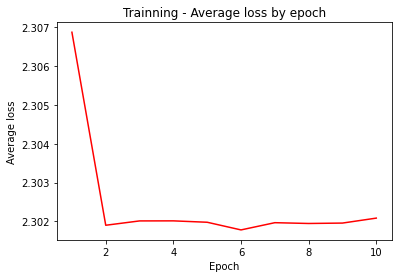



Evaluating models on test data - model  <class '__main__.CNN2'>
Test Accuracy of the model on the 10000 test images: 0.1700

Predicting classes - model  <class '__main__.CNN2'>
Prediction number: [1 1 1 1 1 1 1 1 1 1]
Actual number: [9 0 1 3 4 9 9 9 9 9]
---------------------------------------------------------------------------


Trainning phase - model  <class '__main__.CNN3'> 


CNN3(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  

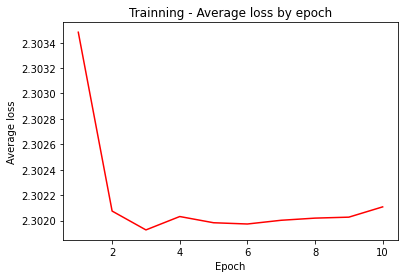



Evaluating models on test data - model  <class '__main__.CNN3'>
Test Accuracy of the model on the 10000 test images: 0.1300

Predicting classes - model  <class '__main__.CNN3'>
Prediction number: [1 1 1 1 1 1 1 1 1 1]
Actual number: [8 9 0 9 0 7 1 3 2 2]
---------------------------------------------------------------------------


Trainning phase - model  <class '__main__.CNN4'> 


CNN4(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  

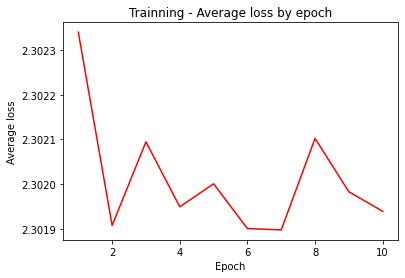



Evaluating models on test data - model  <class '__main__.CNN4'>
Test Accuracy of the model on the 10000 test images: 0.1500

Predicting classes - model  <class '__main__.CNN4'>
Prediction number: [1 1 1 1 1 1 1 1 1 1]
Actual number: [7 7 2 2 2 2 3 5 6 2]
---------------------------------------------------------------------------


Trainning phase - model  <class '__main__.CNN5'> 


CNN5(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  

In [ ]:
models.append(CNN1())
models.append(CNN2())
models.append(CNN3())
models.append(CNN4())
models.append(CNN5())

#Train and test models
for model in models:
  average_loss_by_epoch = train(num_epochs, model, loaders)
  plot_average_loss_by_epoch(average_loss_by_epoch)
  test(model)
  predict_sample_classes(model)
  print("---------------------------------------------------------------------------\n\n")

# Análise sobre os resultados obtidos nos modelos `CNN`